In [1]:
# import related libraries
import numpy as np
from joblib import dump, load
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import xgboost as xgb
import h2o
import json
import pandas as pd

# set random seeds to ensure reproducibility
import random
random.seed(2233)
np.random.seed(2233)

In [3]:
# define some useful utility functions
def get_paths():
    paths = json.loads(open("SETTINGS.json").read())
    return paths

def identity(x):
    return x

# trigger the columns to be parsed as strings or specified data types
converters = { "FullDescription" : identity, "Title": identity, "LocationRaw": identity, "LocationNormalized": identity}

def get_train_df():
    train_path = get_paths()["train_data_path"]
    return pd.read_csv(train_path) # converters=converters

def get_valid_df():
    valid_path = get_paths()["valid_data_path"]
    return pd.read_csv(valid_path) # converters=converters

def get_test_df():
    test_path = get_paths()["test_data_path"]
    return pd.read_csv(test_path) # converters=converters

def save_model(model, filename):
    model_path = get_paths()["model_path"]
    dump(model, model_path + filename)

def load_model(filename):
    model_path = get_paths()["model_path"]
    return load(model_path + filename)

def write_submission(ids, predictions, filename):
    prediction_path = get_paths()["prediction_path"]
    output_dict = {"Id": ids, "SalaryNormalized": predictions}
    output = pd.DataFrame(output_dict)
    output.to_csv(prediction_path + filename, index=False)
    
def save_feature(feature, filename):
    feature_path = get_paths()["feature_path"]
    feature.to_csv(feature_path + filename, index=False)
    
def load_feature(filename):
    feature_path = get_paths()["feature_path"]
    return pd.read_csv(feature_path + filename)

In [4]:
# define a class FeatureMapper for extracting features for different columns automatically in the pipeline
class FeatureMapper(TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        for feature_name, column_name, extractor in self.features:
            extractor.fit(X[column_name], y)
        return self

    def transform(self, X):
        extracted = []
        for feature_name, column_name, extractor in self.features:
            fea = extractor.transform(X[column_name])
            if hasattr(fea, "toarray"):
                extracted.append(fea.toarray()) # convert sparse matrix into dense numpy ndarray
            else:
                extracted.append(fea)
        if len(extracted) > 1:
            return np.concatenate(extracted, axis=1) # concatenate columns
        else: 
            return extracted[0]

    def fit_transform(self, X, y=None):
        extracted = []
        for feature_name, column_name, extractor in self.features:
            fea = extractor.fit_transform(X[column_name], y)
            if hasattr(fea, "toarray"):
                extracted.append(fea.toarray())
            else:
                extracted.append(fea)
        if len(extracted) > 1:
            return np.concatenate(extracted, axis=1)
        else: 
            return extracted[0]

In [5]:
# define a sample transformer class to illustrate how to construct a customized transformer
class SimpleTransformer(TransformerMixin): # BaseEstimator
    def __init__(self, transformer=identity):
        self.transformer = transformer

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([self.transformer(x) for x in X], ndmin=2).T
    
# fit_transform method is inherited from the superclass TransformerMixin, which is the Mixin class for all transformers in scikit-learn

# we can also define a subclass of RegressorMixin to construct a customized final estimator for the pipeline

In [6]:
# get uni-gram CountVectorizer
def get_unigram_CountVectorizer(max_features):
    return CountVectorizer(max_features=max_features)

# get uni-gram TfidfVectorizer
def get_unigram_TfidfVectorizer(max_features):
    return TfidfVectorizer(max_features=max_features)

# get binary uni-gram CountVectorizer for models like Bernoulli Naive Bayes
def get_binary_CountVectorizer(max_features):
    return CountVectorizer(binary=True, max_features=max_features)

In [ ]:
title_indices = list(range(2000))
for key, value in title_vocabulary.items():
    title_indices[value] = key
title_coefs = pd.Series(benchmark_pipeline.named_steps["regression"].coef_[: 2000], index=title_indices)
title_coefs_sorted = title_coefs.abs().sort_values(ascending=False)
title_frequencies = dict()
for i in range(50):
    key = title_coefs_sorted.index[i]
    val = title_coefs_sorted[i]
    title_frequencies[key] = val
wc = WordCloud(background_color="white", max_words=1000, width=800, height = 600, relative_scaling=1)
wc.generate_from_frequencies(title_frequencies)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
# plt.show()
plt.savefig("data/title_word_cloud_2.png")
# for i in range(50):
#     print(title_coefs_sorted.index[i])

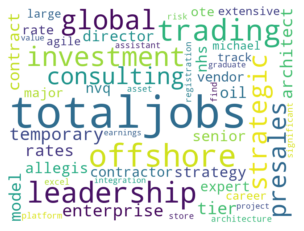

In [34]:
desc_indices = list(range(2000))
for key, value in description_vocabulary.items():
    desc_indices[value] = key
desc_coefs = pd.Series(benchmark_pipeline.named_steps["regression"].coef_[2000: 4000], index=desc_indices)
desc_coefs_sorted = desc_coefs.abs().sort_values(ascending=False)
desc_frequencies = dict()
for i in range(50):
    key = desc_coefs_sorted.index[i]
    val = desc_coefs_sorted[i]
    desc_frequencies[key] = val
wc = WordCloud(background_color="white", max_words=1000, width=800, height=600, relative_scaling=1)
wc.generate_from_frequencies(desc_frequencies)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
# plt.show()
plt.savefig("data/desc_word_cloud_2.png")
# for i in range(50):
#     print(desc_coefs_sorted.index[i])

In [14]:
title_vocabulary = benchmark_pipeline.named_steps["extract_features"].transformers_[0][1].vocabulary_
description_vocabulary = benchmark_pipeline.named_steps["extract_features"].transformers_[1][1].vocabulary_
location_vocabulary = benchmark_pipeline.named_steps["extract_features"].transformers_[2][1].vocabulary_
lasso_coefficients = benchmark_pipeline.named_steps["regression"].coef_

In [66]:
# plot importance
#xgb.plot_importance(xgb_regressor)
print(len(xgb_regressor.feature_importances_))
# plot output tree
# xgb.plot_tree(xgb_regressor, num_trees=2)

array([0.        , 0.        , 0.        , ..., 0.00059254, 0.00056146,
       0.00172982], dtype=float32)

In [9]:
# define some functions for building a data pipeline
def feature_extractor():
    # ('LocationRaw-Bag of Words', 'LocationRaw', CountVectorizer(max_features=100)),
    # ('LocationNormalized-Bag of Words', 'LocationNormalized', CountVectorizer(max_features=100))
    # max_features: build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
    # features = [('FullDescription-Bag of Words', 'FullDescription', CountVectorizer(max_features=100)), ('Title-Bag of Words', 'Title', CountVectorizer(max_features=100))]
    # combined = FeatureMapper(features)
    # return combined
    return ColumnTransformer([("Title", TfidfVectorizer(max_features=3000, ngram_range=(2,2)), 0), 
                              ("FullDescription", TfidfVectorizer(max_features=3000, ngram_range=(2,2)), 1), 
                              ("LocationNormalized", CountVectorizer(), 2),
                              ("ContractType", OneHotEncoder(), [3]), 
                              ("ContractTime", OneHotEncoder(),[4]), 
                              ("Category", OneHotEncoder(), [5])], 
                             remainder="passthrough")
    # ('remainder', 'drop', [2, 3, 4, 5]) ?

def SVD_feature_extractor():
    return ColumnTransformer([("Title", TfidfVectorizer(max_features=2000), 0), 
                              ("FullDescription", Pipeline([("tfidf", TfidfVectorizer(max_features=2000)), 
                                                            ("best", TruncatedSVD(n_components=1000))]), 1), 
                              ("LocationNormalized", CountVectorizer(), 2),
                              ("ContractType", OneHotEncoder(), [3]), 
                              ("ContractTime", OneHotEncoder(),[4]), 
                              ("Category", OneHotEncoder(), [5])], 
                             remainder="passthrough")
    
def xgboost_regressor():
    return xgb.XGBRegressor(max_depth=15, learning_rate=0.2, min_child_weight=4, subsample=0.9, colsample_bytree=0.9) # n_estimators=10
    
def lasso_regressor():
    return Lasso()

def randomforest_regressor():
    return RandomForestRegressor(n_estimators=50, verbose=2, n_jobs=-2, min_samples_split=30) # min_samples_split=30

# get a pipeline to automatically extract features and train models
def get_pipeline(features, estimator):
    steps = [("extract_features", features), ("regression", estimator)] # use memory parameter of pipeline to cache transformer since fitting 
                                                                # transformers could be expensive.
    return Pipeline(steps=steps, verbose=True) # memory="data/feature/"

In [ ]:
# train and save model
print("Reading in the training data")
train = get_train_df()

print("Extracting features")
# benchmark_pipeline = get_pipeline(feature_extractor(), lasso_regressor())
las_regressor = lasso_regressor()
xgb_regressor = xgboost_regressor()
rf_regressor = randomforest_regressor()
benchmark_pipeline = get_pipeline(SVD_feature_extractor(), xgb_regressor)

X_train = train.drop(columns="SalaryNormalized")
y_train = train.SalaryNormalized
# y_train = np.log(train.SalaryNormalized)

print("Fitting the pipeline")
benchmark_pipeline.fit(X_train, y_train) # should train remove SalaryNormalized column? look at FeatureMapper

# print("Saving the fitted pipeline")
# save_model(benchmark_pipeline, "benchmark_pipeline.joblib")

In [ ]:
# make predictions for a model
print("Loading the classifier")
# classifier = load_model("benchmark_pipeline.joblib")
classifier = benchmark_pipeline

print("Making predictions on train set")
train = get_train_df()
X_train = train.drop(columns="SalaryNormalized")
y_pred_train_benchmark = classifier.predict(X_train) # np.exp()

print("Making predictions on validation set") 
valid = get_valid_df()
X_valid = valid.drop(columns="SalaryNormalized")
y_pred_valid_benchmark = classifier.predict(X_valid) # a single line to apply transform and predict, no fit.
                                        # the same transforming (as to the train set) to the validation set and predict salary.
# y_pred_valid_benchmark = y_pred_valid_benchmark.reshape(len(y_pred_valid_benchmark), 1)

print("Making predictions on test set")
test = get_test_df()
X_test = test.drop(columns="SalaryNormalized")
y_pred_test_benchmark = classifier.predict(X_test)

# write predictions into local csv file for submission
# print("Writing predictions to file")
# write_submission(ids, predictions, filename)

In [ ]:
# print performance metrics for each model on train set
train = get_train_df()
def get_mae_train(clf_name, predictions):
    print("The MAE for %s on train set is %.4f" % (clf_name, metrics.mean_absolute_error(train.SalaryNormalized, predictions)))
    
get_mae_train("lasso regression", y_pred_train_benchmark)

In [ ]:
# print performance metrics for each model on validation set
valid = get_valid_df()
def get_mae_valid(clf_name, predictions):
    print("The MAE for %s on validation set is %.4f" % (clf_name, metrics.mean_absolute_error(valid.SalaryNormalized, predictions)))
    
get_mae_valid("lasso regression", y_pred_valid_benchmark)

In [ ]:
# print performance metrics for each model on test set
test = get_test_df()
def get_mae_test(clf_name, predictions):
    print("The MAE for %s on test set is %.4f" % (clf_name, metrics.mean_absolute_error(test.SalaryNormalized, predictions)))
    
get_mae_test("lasso regression", y_pred_test_benchmark)

In [43]:
# read train, validation and test set
train = get_train_df()
valid = get_valid_df()
test = get_test_df()

In [31]:
# log-transform salaryNormalized ?

In [32]:
# drop [id, locationRaw, salaryRaw, sourceName]
# test.drop(columns="SourceName", inplace=True)

# number of unique values for Company is 15053
# number of unique values for LocationNormalized is 2177

# drop [company, locationNormalized] columns or treat them as categorical variables ?
print(train.columns)

Index(['Title', 'FullDescription', 'LocationNormalized', 'ContractType',
       'ContractTime', 'Category', 'SalaryNormalized'],
      dtype='object')


In [14]:
# use sklearn TfidfVectorizer
tfidf_vectorizer_100 = get_unigram_TfidfVectorizer(100)

# use sklearn CountVectorizer
count_vectorizer_100 = get_unigram_CountVectorizer(100)

In [35]:
# process Title
title_tfidf_100 = tfidf_vectorizer_100.fit_transform(train.Title)
print(title_tfidf_100.shape)
print(type(title_tfidf_100))

# title_tfidf_100.toarray
# title_tfidf_100.todense
# title_tfidf_100 = pd.DataFrame(title_tfidf_100.toarray)

# save_feature(title_tfidf_100, "title_tfidf_100.csv")

(117488, 100)
<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
# feature selection
# remove Id, LocationRaw, Company, SalaryRaw, SourceName variables before model training
train_data = get_train_df()
train = train_data.drop(columns=["Id", "LocationRaw", "Company", "SalaryRaw", "SourceName", "NUM_RAND"])

# treat SalaryNormalized as target variable
X = train.drop(columns="SalaryNormalized")
y = train_data.SalaryNormalized

In [ ]:
# convert categorical variables to dummy variables since xgboost only accepts numeric variables 

# train xgboost model
data = X
label = pandas.DataFrame(y)
dtrain = xgb.DMatrix(data, label=label)

param = {'max_depth':15, 'eta':0.2, 'eval_metric':'mae', 'min_child_weight':4, 'subsample':0.9, 'colsample_bytree':0.9} 
# 'max_depth':2, 'eta':1, 'objective':'binary:logistic', 'nthread':4
# eval_list = [(dtest, 'eval'), (dtrain, 'train')]
eval_list = [(dtrain, 'train')]
num_round = 10
xgb_clf = xgb.train(param, dtrain, num_round, eval_list) # eval_list

# save model
xgb_clf.save_model("xgb_01.model")

# load model
xgb_clf = xgb.Booster({'nthread': 4})  # init model
xgb_clf.load_model('model.bin')  # load data

# missing values can be replaced by a default value in the DMatrix constructor
# dtrain = xgb.DMatrix(data, label=label, missing=-999.0)

In [ ]:
# predict using xgboost model
test = get_test_df()

# extract features from test set using sklearn vectorizers
test = tfidf_vectorizer.transform(test)

# store test set in xgb.DMatrix
dtest = xgb.DMatrix(test)

# make predictions
ypred = xgb_clf.predict(dtest)

In [ ]:
# plot importance
xgb.plot_importance(xgb_clf)

# plot output tree
xgb.plot_tree(xgb_clf, num_trees=2)

In [ ]:
# train h2o deep network model
h2o.init()

In [ ]:
# CountVectorizer with max_df and min_df